# A Big Big-Five Personality Factors Example

We'll begin by downloading and pre-processing the data set, which consists of over 1 million people's responses to 50 Big 5 items (10 items/factor, 5 categories/item).

After some basic pre-processing, we cut the data down to around 695K people.

In [1]:
import os
import urllib.request
import shutil
import pandas as pd

from utils import *
from figures import *

# Download data.
filepath = "./data/IPIP-FFM-data-8Nov2018/data-final.csv"
if not os.path.exists(filepath):
    os.makedirs(os.path.dirname("./data/"), exist_ok=True)
    urllib.request.urlretrieve("https://openpsychometrics.org/_rawdata/IPIP-FFM-data-8Nov2018.zip",
                               "./data/ipip-ffm.zip")
    shutil.unpack_archive("./data/ipip-ffm.zip", "./data/")

# Pre-processing.
data = pd.read_csv(filepath, sep = "\t", header = 0)
data = data[data["IPC"] == 1] # Drop multiple submissions from same IP address
data.iloc[:, 0:50] = data.iloc[:, 0:50].dropna() # Drop NaNs
data = data[data.iloc[:, 0:50].sum(1) > 0] # Drop all missing responses
reverse_coded_items = ["EXT2", "EXT4", "EXT6", "EXT8", "EXT10", "AGR1", "AGR3", "AGR5", "AGR7",
                       "CSN2", "CSN4", "CSN6", "CSN8", "EST2", "EST4", "OPN2", "OPN4", "OPN6"]
data[reverse_coded_items] = (1 - data[reverse_coded_items] / 5) * 5 # Fix reverse-coded items
data = torch.from_numpy(data.iloc[:, 0:50].to_numpy()) - 1
missing_mask = 1 * (data != -1)
data[data == -1] = 0

print(data.shape)

torch.Size([694512, 50])


## Exploratory Item Factor Analysis

We'll first conduct exploratory item factor analysis (IFA).

A typical goal in this context is to determine the number of latent factors underlying the data. We can do this using a log-likelihood (LL) scree plot approach where we fit a number of models with different latent dimensions and estimate the LL on a held-out data set for each dimension. We then plot these LLs and pick the latent dimension corresponding to an "elbow" in the plot.


Latent size =  3

Fitting started
Epoch =       1 Iter. =  26601   Current mean loss = 61.75   Intervals no change = 100
Fitting ended in  84.61  seconds

Computing approx. LL
Approx. LL computed in 15.01 seconds

Latent size =  4

Fitting started
Epoch =       0 Iter. =  17901   Current mean loss = 60.31   Intervals no change = 100
Fitting ended in  53.14  seconds

Computing approx. LL
Approx. LL computed in 14.55 seconds

Latent size =  5

Fitting started
Epoch =       1 Iter. =  27501   Current mean loss = 59.60   Intervals no change = 100
Fitting ended in  85.46  seconds

Computing approx. LL
Approx. LL computed in 16.86 seconds

Latent size =  6

Fitting started
Epoch =       0 Iter. =  17801   Current mean loss = 59.42   Intervals no change = 100
Fitting ended in  53.24  seconds

Computing approx. LL
Approx. LL computed in 17.6 seconds

Latent size =  7

Fitting started
Epoch =       1 Iter. =  27701   Current mean loss = 59.15   Intervals no change = 100
Fitting ended in  83.09

/Users/gateslab/school/code/DeepIRTools/figures.py:85: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


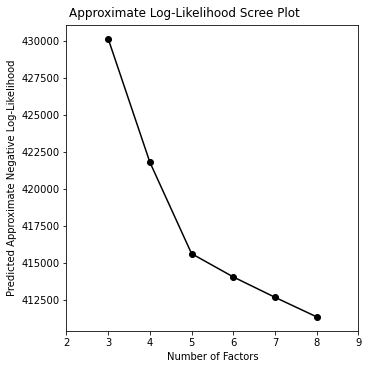

In [2]:
n_items = data.shape[1]

# This will take a few minutes to run.
ll_list = screeplot(latent_sizes = [int(i + 1) for i in range(2, 8)],
                    data = data,
                    n_cats = [5] * n_items,
                    test_size = 0.01,
                    inference_net_sizes_list = [[100]] * 10,
                    learning_rates = [5e-3] * 10,
                    missing_mask = missing_mask,
                    device = "cpu",                  
                    iw_samples_fit = 5,
                    iw_samples_ll = 500,
                   )

Another goal in the exploratory context is to uncover the factor loadings structure.

Since we found an "elbow" at 5 latent factors, we fit a 5-factor IFA model with unconstrained loadings and standard normal factors. We then use Geomin oblique rotation from the FactorAnalyzer package to produce rotated loadings, which have a clear simple structure.


Fitting started
Epoch =       0 Iter. =  16601   Current mean loss = 59.72   Intervals no change = 100
Fitting ended in  52.82  seconds


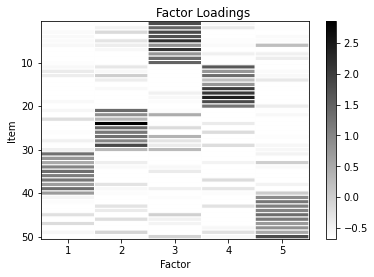

In [3]:
from factor_analyzer import Rotator

model = ImportanceWeightedEstimator(learning_rate = 5e-3,
                                    device = "cpu",
                                    log_interval = 100,
                                    input_size = n_items,
                                    inference_net_sizes = [100],
                                    latent_size = 5,
                                    n_cats = [5] * n_items,
                                   )
model.fit(data, missing_mask=missing_mask, iw_samples=5)

rotator = Rotator(method = "geomin_obl")
rot_loadings = rotator.fit_transform(model.loadings)
loadings_heatmap(rot_loadings)

## Confirmatory Item Factor Analysis

In the confirmatory IFA setting, researchers have *a priori* theories about the loadings structure which they want to test for goodness-of-fit.

There are several ways to implement these constraints. One is to use a binary matrix *Q* whose elements are zero if the corresponding loading is set to zero and one otherwise.

We demonstrate this by imposing simple stucture on the loadings matrix using *Q* below. We also estimate the correlations between the latent factors.

In [4]:
Q = torch.block_diag(*[torch.ones([10, 1])] * 5)

model = ImportanceWeightedEstimator(learning_rate = 5e-3,
                                    device = "cpu",
                                    log_interval = 100,
                                    Q = Q,
                                    input_size = n_items,
                                    inference_net_sizes = [100],
                                    latent_size = 5,
                                    n_cats = [5] * n_items,
                                    correlated_factors = [0, 1, 2, 3, 4],
                                   )
model.fit(data, missing_mask=missing_mask, iw_samples=5)

print("\n", np.around(model.loadings, 2))
print("\n", np.around(model.cov, 2))


Fitting started
Epoch =       0 Iter. =  18701   Current mean loss = 60.52   Intervals no change = 100
Fitting ended in  88.9  seconds

 tensor([[1.7800, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.6700, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.9600, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.9200, 0.0000, 0.0000, 0.0000, 0.0000],
        [2.3500, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.3000, 0.0000, 0.0000, 0.0000, 0.0000],
        [2.2300, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0900, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.4700, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.7900, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.8900, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.1400, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.5100, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9100, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.2100, 0.0000, 0.0000, 0.0000],
        [0.0000, 2.1300, 0.0000, 0.0000, 0.0000],
        [0.0000, 2.2700, 0.0000, 0.0000, 0.0000],
        [0.0

We can implement a wider range of confirmatory IFA models using linear constraints encoded in a matrix *A* and a vector *b*. We implement the same model we just fitted using linear constraints below.

In [5]:
constraint_ls = ([torch.eye(10), torch.zeros([n_items, n_items]),
                  torch.eye(10), torch.zeros([n_items, n_items]),
                  torch.eye(10), torch.zeros([n_items, n_items]),
                  torch.eye(10), torch.zeros([n_items, n_items]),
                  torch.eye(10)])
A = torch.block_diag(*constraint_ls)
b = torch.cat(([torch.ones([1]), torch.zeros([9 + n_items]),
                torch.ones([1]), torch.zeros([9 + n_items]),
                torch.ones([1]), torch.zeros([9 + n_items]),
                torch.ones([1]), torch.zeros([9 + n_items]),
                torch.ones([1]), torch.zeros([9])]), dim=0)

model = ImportanceWeightedEstimator(input_size = n_items,
                                    inference_net_sizes = [100],
                                    latent_size = 5,
                                    n_cats = [5] * n_items,
                                    learning_rate = 5e-3,
                                    A = A,
                                    b = b,
                                    device = "cpu",
                                    log_interval = 100,
                                    correlated_factors = [0, 1, 2, 3, 4],
                                   )
model.fit(data, missing_mask=missing_mask, iw_samples=5)

print("\n", np.around(model.loadings, 2))
print("\n", np.around(model.cov, 2))


Fitting started
Epoch =       0 Iter. =  19801   Current mean loss = 60.63   Intervals no change = 100
Fitting ended in  95.08  seconds

 tensor([[1.8500, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.7300, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.8900, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.9900, 0.0000, 0.0000, 0.0000, 0.0000],
        [2.3800, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.3700, 0.0000, 0.0000, 0.0000, 0.0000],
        [2.2100, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.1300, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.4900, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.7600, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.7800, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.1100, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.4300, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8200, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.2400, 0.0000, 0.0000, 0.0000],
        [0.0000, 2.2100, 0.0000, 0.0000, 0.0000],
        [0.0000, 2.2600, 0.0000, 0.0000, 0.0000],
        [0.